In [ ]:
import os.path as osp
from helper import find_best_model_in_metric_file  
import matplotlib.pylab as plt
from collections import  defaultdict
from general_tools.simpletons import sort_dict_by_key

In [ ]:
%matplotlib inline

In [ ]:
top_sample_dir = '/orions4-zfs/projects/optas/DATA/OUT/iclr/synthetic_samples/'
top_evaluation_dir = '/orions4-zfs/projects/optas/DATA/OUT/iclr/evaluations/synthetic_data/'

In [ ]:
def stored_synthetic_samples(class_name):
    sample_dir = {'l_gan_emd': osp.join(top_sample_dir, 'l_gan/l_gan_' + class_name + '_mlp_with_split_1pc_usampled_bnorm_on_encoder_only_emd_bneck_128'),
                  'l_gan_chamfer': osp.join(top_sample_dir, 'l_gan/l_gan_' + class_name + '_mlp_with_split_1pc_usampled_bnorm_on_encoder_only_chamfer_bneck_128'),
                  'l_w_gan_small': osp.join(top_sample_dir, 'l_w_gan/l_w_gan_'+ class_name + '_mlp_with_split_1pc_usampled_bnorm_on_encoder_only_emd_bneck_128_lgan_arch'),
                  'l_w_gan_large': osp.join(top_sample_dir, 'l_w_gan/l_w_gan_'+ class_name + '_mlp_with_split_1pc_usampled_bnorm_on_encoder_only_emd_bneck_128_lgan_arch_double_neurons'),
                  'r_gan': osp.join(top_sample_dir, 'r_gan/r_gan_' + class_name + '_mlp_disc_4_fc_gen_raw_gan_2048_pts'),
                  'gmm': osp.join(top_sample_dir, 'gmm/gmm_emd_' + class_name)
                 }
    
    return sample_dir

In [ ]:
def read_evaluation_file(in_file):
    all_lines = []
    res = dict()
    with open(in_file, 'r') as fin:
        for line in fin:
            l = line.rstrip()
            if len(l) > 0:
                all_lines.append(l)
    return all_lines

def tokenize_evaluation_data(in_lines, metric):
    current_model = None
    data_dict = defaultdict(dict)
    
    def model_name(model):
        if model.startswith('epoch'):
            return int(model[len('epoch_'):])

        elif model.endswith('gaussians'):
            tok = model.split('_')
            cov_type = tok[-3]
            n_gaussians = tok[-2]
            return cov_type + '_' + n_gaussians
            
    for line in in_lines:
        token = line.split()
        if token[0] not in ['train', 'test', 'val']:
            current_model = model_name(token[0])        # Varying epoch or n_gaussians 
        else:
            if 'mmd' in metric.lower():       
                split, metric_value, metric_std = token # split - mean - std
            else:
                split, metric_value = token
                metric_std = 0
                
            metric_value = float(metric_value)
            metric_std = float(metric_std)
            data_dict[split][current_model] = (metric_value, metric_std)            
    return data_dict
    
    
def find_best_model_in_metric_file(in_file, metric, sort_by='test', report=['train', 'test', 'val']):    
    all_lines = read_evaluation_file(in_file)
    data_dict = tokenize_evaluation_data(all_lines, metric)
    stats = data_dict[sort_by]
    best_model = sorted([(stats[s][0], stats[s][1], s) for s in stats.keys()])[0]
    res = dict()
    for s in report:
        res[s] = (best_model[2], data_dict[s][best_model[2]])        
    return res

def stats_per_epoch_or_n_clusters(data_dict, mu=True, split='train'):
    d = data_dict[split]
    x = []
    y = []
    e = []
    for key, val in sort_dict_by_key(d):
        x.append(key)
        y.append(val[0])
        e.append(val[1])
    return x, y, e

In [ ]:
class_name = 'chair'
exp_dict = stored_synthetic_samples(class_name)

In [ ]:
def collect_data_for_all_experiments(metric):
    data_col = dict()
    for key in exp_dict.keys(): 
        exp_name = osp.basename(exp_dict[key]) 
        in_file = osp.join(top_evaluation_dir, class_name, metric, exp_name + '.txt')
        all_lines = read_evaluation_file(in_file)
        data_col[key] = tokenize_evaluation_data(all_lines, metric)
    return data_col
    
boost_5 = collect_data_for_all_experiments('mmd_chamfer_all_gt_boost_sample_5')
emd_40_200 = collect_data_for_all_experiments('mmd_emd_10_samples_40gt_200_synthetic')

In [ ]:
boost_5['gmm']

In [86]:
# metric = 'mmd_emd_10_samples_40gt_200_synthetic'
# metric =  'mmd_chamfer_all_gt_boost_sample_5'
metric = 'jsd'

legend_names = []
for key in exp_dict.keys():
    print key
    exp_name = osp.basename(exp_dict[key]) 
    try:
        in_file = osp.join(top_evaluation_dir, class_name, metric, exp_name + '.txt')
        best_model = find_best_model_in_metric_file(in_file, sort_by='test')
        print best_model['test']
        print best_model['train']
        print best_model['val']
        best_id = best_model['val'][0]
        print best_id
        print boost_5[key]['val'][best_id]
                
#         if 'gan' in exp_name:
#             legend_names.append(key)
#             x, y, e = stats_per_epoch_or_n_clusters(data_dict, split='test')
#             plt.plot(x, y)
#             plt.errorbar(x, y, yerr=e, fmt='-o')    
    except:
        pass
#     plt.legend(legend_names)
#     plt.title('MMD via EMD:10-40-200 on Test')
#     plt.title('MMD via CD :5x_boost, Test')


l_w_gan_large
(1800, (0.0129051323397, 0.0))
(1800, (0.00575715240621, 0.0))
(1800, (0.0232135225627, 0.0))
1800
(0.00182876, 0.00107758)
gmm
('full_32', (0.0116601563822, 0.0))
('full_32', (0.0048985564863, 0.0))
('full_32', (0.0195082775895, 0.0))
full_32
(0.00178594, 0.000985896)
r_gan
(1700, (0.168318301096, 0.0))
(1700, (0.166008910939, 0.0))
(1700, (0.174395941161, 0.0))
1700
(0.0020074, 0.00129437)
l_gan_chamfer
(300, (0.0392821033717, 0.0))
(300, (0.037283807901, 0.0))
(300, (0.0432948085431, 0.0))
300
(0.00195145, 0.00142163)
l_w_gan_small
(1800, (0.0151715749576, 0.0))
(1800, (0.00776201578168, 0.0))
(1800, (0.0216213965001, 0.0))
1800
(0.00189966, 0.00106629)
l_gan_emd
(100, (0.0278214518934, 0.0))
(100, (0.0188023663357, 0.0))
(100, (0.0304988906138, 0.0))
100
(0.0022182, 0.00175354)


['l_gan_chai']

[('epoch_1', 0.565079913793), ('epoch_5', 0.189998208), ('epoch_10', 0.144929599114), ('epoch_100', 0.0188023663357), ('epoch_200', 0.019968082549), ('epoch_300', 0.0212707079852), ('epoch_400', 0.0260263323931), ('epoch_500', 0.0319902814686), ('epoch_600', 0.0410287836666), ('epoch_700', 0.0453361305382), ('epoch_800', 0.0490666616269), ('epoch_900', 0.0571608591114), ('epoch_1000', 0.0655948237147), ('epoch_1100', 0.072259531547), ('epoch_1200', 0.0775247490998), ('epoch_1300', 0.0839207411086), ('epoch_1400', 0.0888661407953), ('epoch_1500', 0.0969888565771), ('epoch_1600', 0.101222055355), ('epoch_1700', 0.109395842314), ('epoch_1800', 0.113843501558), ('epoch_1900', 0.119827432313), ('epoch_2000', 0.720983298393)]


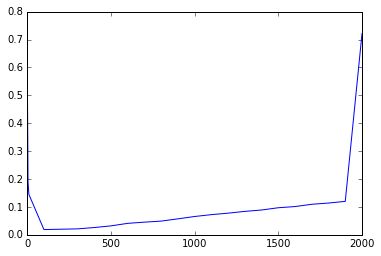

In [78]:
plot_stats_per_epoch()
